In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [3]:
#Importar datos
dfA = pd.read_excel('../01 - Datos bruto/01.21-12.22.xlsx')
dfB = pd.read_excel('../01 - Datos bruto/12.22-12.23.xlsx')
dfC = pd.read_excel('../01 - Datos bruto/12.23-07.24.xlsx')

## 1: Limpieza y preparación del Dataset

In [4]:
#Concatenar
df = pd.concat([dfA, dfB, dfC])

In [5]:
#Checkear duplicados
df.duplicated().sum()

2837

In [6]:
#Eliminar duplicados
df = df.drop_duplicates()

In [7]:
#Renombrar columnas
columnas = ['nodos','fecha_arch', 'hora_arch', 'scanner', 'codigo', 'unidad_manipulac', 'entrega', 'posicion', 'doc_ventas', 'posicion2', 'material', 'denominacion', 'fecha_hist', 'hora_hist']
df = df.set_axis(columnas, axis = 1)

In [8]:
#Eliminar espacios antes y despues de strings
columns_to_strip = ['material', 'denominacion']
for col in columns_to_strip:
    df[col] = df[col].astype(str).str.strip()

In [9]:
#Combinar fechas históricas y archivadas
df = df.reset_index(drop=True)
df['fecha_arch'] = pd.to_datetime(df['fecha_arch'].str.strip(), format='%d.%m.%Y', errors='coerce')
df['fecha_hist'] = pd.to_datetime(df['fecha_hist'].str.strip(), format='%d.%m.%Y', errors='coerce')
df['fecha'] = df['fecha_arch'].combine_first(df['fecha_hist'])

In [10]:
#Combianr horas históricas y archivadas
df = df.reset_index(drop=True)
df['hora_arch'] = df['hora_arch'].astype(str)
df['hora_hist'] = df['hora_hist'].astype(str)
df['hora_arch'] = pd.to_timedelta(df['hora_arch'].str.strip(), errors='coerce')
df['hora_hist'] = pd.to_timedelta(df['hora_hist'].str.strip(), errors='coerce')
df['hora'] = df['hora_arch'].combine_first(df['hora_hist'])

In [11]:
#Eliminar fechas y horas previas a la combinación
df = df.drop(['fecha_arch', 'hora_arch', 'fecha_hist', 'hora_hist'], axis = 1)

In [12]:
#Calcular el turno donde se ha escaneado el producto
def calcular_turno(row):
    if row['hora'] >= pd.to_timedelta('01:00:00') and row['hora'] <= pd.to_timedelta('15:15:00'):
        return 1
    else:
        return 2
    
df['turno'] = df.apply(calcular_turno, axis=1)

In [13]:
#Calcular mes y año
df['mes'] = df['fecha'].dt.month
df['year'] = df['fecha'].dt.year

In [14]:
df

,nodos,scanner,codigo,unidad_manipulac,entrega,posicion,doc_ventas,posicion2,material,denominacion,fecha,hora,turno,mes,year
0,MADR,SAPRFMADR16,ZRF_M7,2314925272,89172516,20,9712112,30,P845_USTORAGE_HGD,USNG ARMARIO P/BAT,2021-01-04,0 days 07:06:35,1,1,2021
1,MADR,SAPRFMADR19,ZRF_M7,2314925292,89174813,50,9711027,70,P1072551,DIVISIO FRAMELESS SCR - DESK CONNECTORS,2021-01-04,0 days 07:09:18,1,1,2021
2,MADR,SAPRFMADR19,ZRF_M2,2314925273,89170341,10,9708990,30,P1072551,DIVISIO FRAMELESS SCR - DESK CONNECTORS,2021-01-04,0 days 07:11:45,1,1,2021
3,MADR,SAPRFMADR23,ZRF_M1,2314925312,89172410,20,9710338,70,P5SP_PCUS86468,TOP A1600 P800 W/TA ACTIVA TT1,2021-01-04,0 days 07:12:32,1,1,2021
4,MADR,SAPRFMADR23,ZRF_M1,2314925313,89172410,20,9710338,70,P5SP_PCUS86468,TOP A1600 P800 W/TA ACTIVA TT1,2021-01-04,0 days 07:12:35,1,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481130,MADR,SAPRFMADR26,ZRF_M1,2316412904,96027592,70,1411736,2000,P5SP_1900434,Band 1/2 bench 1600,2024-07-18,0 days 22:42:58,2,7,2024
1481131,MADR,SAPRFMADR26,ZRF_M1,2316412905,96027592,70,1411736,2000,P5SP_1900434,Band 1/2 bench 1600,2024-07-18,0 days 22:43:34,2,7,2024
1481132,MADR,SAPRFMADR26,ZRF_M1,2316412906,96027592,70,1411736,2000,P5SP_1900434,Band 1/2 bench 1600,2024-07-18,0 days 22:44:30,2,7,2024
1481133,MADR,SAPRFMADR26,ZRF_M1,2316412907,96027592,70,1411736,2000,P5SP_1900434,Band 1/2 bench 1600,2024-07-18,0 days 22:47:32,2,7,2024


## 2: EDA DE LA PLANTA

In [15]:
#Filtrar escáneres relevantes
scanners = ['SAPRFMADR26', 'SAPRFMADR20', 'SAPRFMADR23', 'SAPRFMADR16', 'SAPRFMADR19', 'SAPRFMADR21', 'SAPRFMADR17', 'SAPRFMADR18', 'SAPRFMADR15', 'SAPRFMADR24', 'SAPRFMADR25']
df = df[df['scanner'].isin(scanners)]

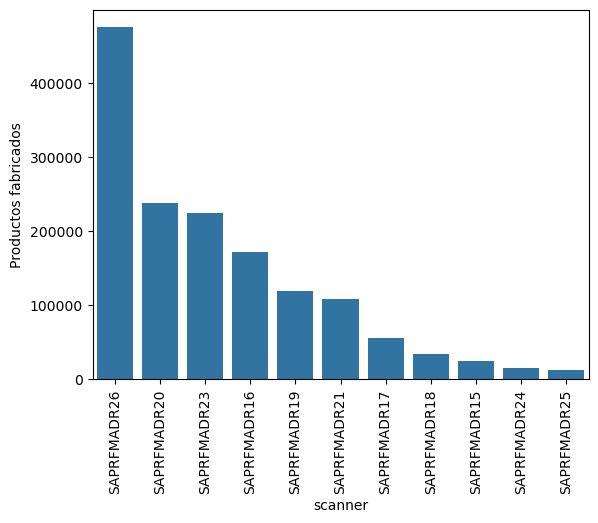

In [16]:
#Cantidad de referencias fabricadas por cada scanner:
sns.barplot(data = df.groupby('scanner').agg({'nodos': 'count' }).sort_values(by = 'nodos', ascending = False), x='scanner', y='nodos' )
plt.xticks(rotation = 90)
plt.ylabel('Productos fabricados')
plt.show()

#SAPRFMADR26 = Mesas
#SAPRFMADR20 = Paneles
#SAPRFMADR23 = Tableros
#SAPRFMADR16 = Volumenes
#SAPRFMADR19 = Conectores
#SAPRFMADR21 = Varios
#SAPRFMADR17 = Silla DO
#SAPRFMADR18 = Pie Ajustable
#SAPRFMADR15 = Bloques
#SAPRFMADR24 = Carpinteria otros
#SAPRFMADR25 = Partito Rail

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17864\378444751.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([scanner_nombres.get(item, item) for item in df_grouped.index])


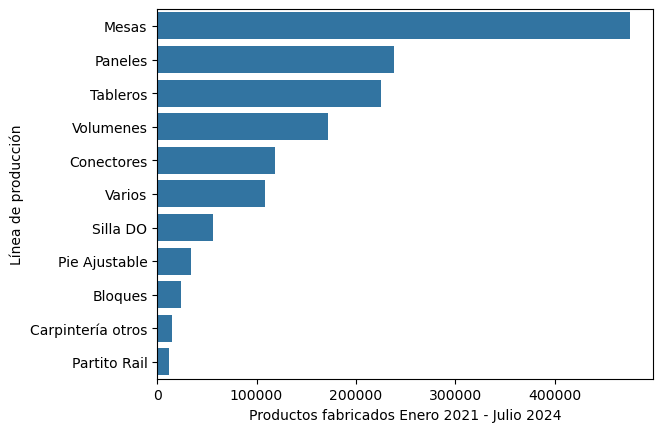

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Diccionario que asocia cada scanner con su respectivo nombre de línea
scanner_nombres = {
    'SAPRFMADR26': 'Mesas',
    'SAPRFMADR20': 'Paneles',
    'SAPRFMADR23': 'Tableros',
    'SAPRFMADR16': 'Volumenes',
    'SAPRFMADR19': 'Conectores',
    'SAPRFMADR21': 'Varios',
    'SAPRFMADR17': 'Silla DO',
    'SAPRFMADR18': 'Pie Ajustable',
    'SAPRFMADR15': 'Bloques',
    'SAPRFMADR24': 'Carpintería otros',
    'SAPRFMADR25': 'Partito Rail'
}

# Agrupar datos
df_grouped = df.groupby('scanner').agg({'nodos': 'count' }).sort_values(by='nodos', ascending=False)

# Crear gráfico de barras horizontal
ax = sns.barplot(data=df_grouped, x='nodos', y=df_grouped.index, orient='h')

# Cambiar las etiquetas del eje Y por los nombres de las líneas
ax.set_yticklabels([scanner_nombres.get(item, item) for item in df_grouped.index])

# Etiquetas de los ejes
plt.xlabel('Productos fabricados Enero 2021 - Julio 2024')
plt.ylabel('Línea de producción')

# Mostrar gráfico
plt.show()


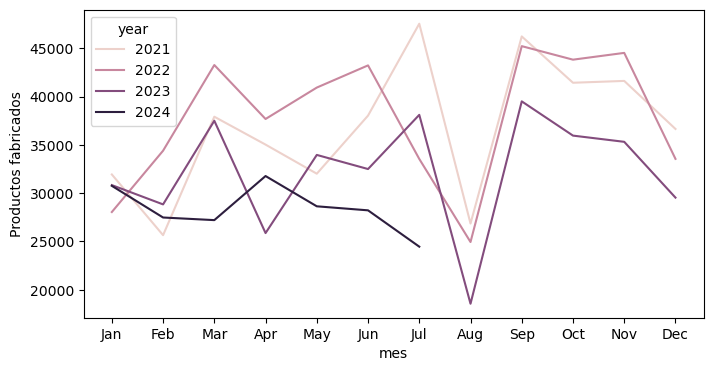

In [18]:
plt.figure(figsize=(8, 4))  #
sns.lineplot(data = df.groupby(['mes', 'year']).agg({'nodos': 'count'}), x= 'mes', y= 'nodos', hue = 'year')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Productos fabricados')
plt.show()

## 2: EDA DE LA LÍNEA DE LINEA VOLÚMENES Y BLOQUES (SAPRFMADR15 + SAPRFMADR16)

In [19]:
#Filtrar la linea de volúmenes y bloques
df_vols = df[(df['scanner'] == 'SAPRFMADR16') | (df['scanner'] == 'SAPRFMADR15')]

In [20]:
# Calculamr diferencia de tiempos entre piezas
df_vols['delta'] = df_vols['hora'].diff().dt.total_seconds()

In [21]:
# Agregamos estado que represente si la pieza se ha producido tras un cambio de producto.
df_vols['cambio'] = (df_vols['material'] != df_vols['material'].shift()).astype(int)

# Añadimos un estado que represente pausas de > 10 mins
df_vols['pausa'] = ((df_vols['delta'] > 600) | (df_vols['delta'] < 0)).astype(int)

### Estudiar Takt Times

In [22]:
# Estudiamos Takt Times de los volumenes filtrando los que se han hecho tras una pausa y tras cambio de producto.
# Estudiamos Takt Times en turno 1 ya que la mano de obra es aproximádamente constante

df_vols_takt_filtr = df_vols[(df_vols['cambio'] == 0) & (df_vols['pausa'] == 0) & (df_vols['turno'] == 1)]

df_vols_takt_filtr_agrup = df_vols_takt_filtr.groupby(
    ['denominacion']
).agg({'delta' : ['mean', 'std', 'count']}).reset_index()

df_vols_takt_filtr_agrup.columns = ['denominacion', 'media_takt', 'dev_std', 'fabricados']
df_vols_takt_filtr_agrup = df_vols_takt_filtr_agrup.sort_values(by = 'fabricados', ascending= False)
df_vols_takt_filtr_agrup.to_csv('./dataframes/df_vols_takt_filtr_agrup.csv')

In [23]:
#Tabla con productos mas fabricados, desviación estandar y Takt Time
df_vols_takt_filtr_agrup.head(10)

,denominacion,media_takt,dev_std,fabricados
205,BLQ IMPL 785/786,84.325797,66.382879,38527
64,ARM US3 PTA PERS,91.192752,58.221678,22075
219,BLQ VA 332/432 C/R 9/10/13 UN,84.943343,61.661339,5295
60,ARM US3 PTA BAT MET,102.445445,57.523491,4665
282,ESTA RECI 850X1000X450 SERI C/SUJ BOLSA,86.725952,49.005807,3992
58,ARM US3 PTA BAT LAM,105.737745,60.339736,3264
209,BLQ IMPL C/R F MET 9/10UN P588,90.617925,70.640602,2332
77,ARM VA2 CLIP PTA BAT MET P470,114.611212,61.730440,2194
76,ARM VA2 CLIP PTA BAT LAM P470,114.272642,63.349710,2142
632,USNG ARMARIO PERS,88.475054,63.462713,1844


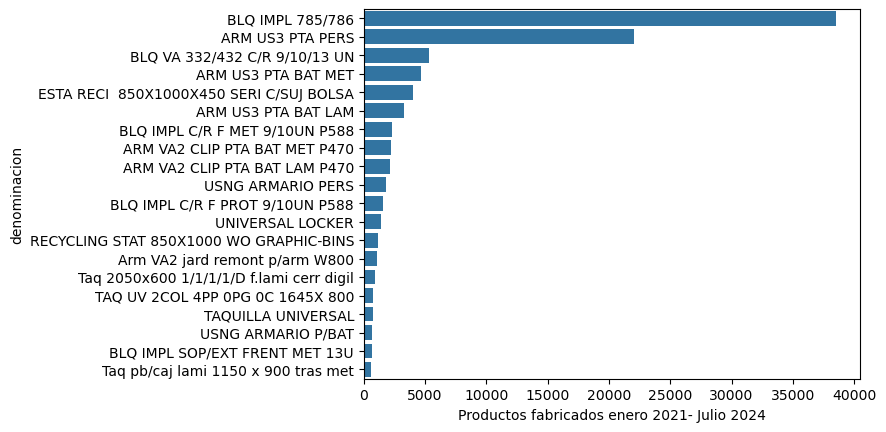

In [24]:
#Se observa Paretto claro en referencias fabricadas
sns.barplot(data = df_vols_takt_filtr_agrup.head(20), x= 'fabricados', y= 'denominacion')
plt.xlabel('Productos fabricados enero 2021- Julio 2024')
plt.show()

Text(0, 0.5, 'Cantidad de productos')

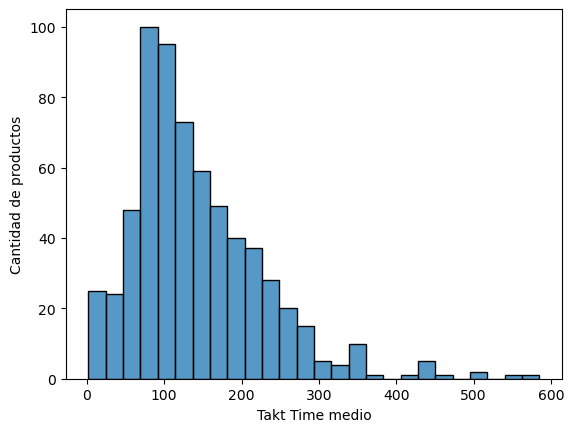

In [25]:
sns.histplot(data = df_vols_takt_filtr_agrup, x= 'media_takt')
plt.xlabel('Takt Time medio')
plt.ylabel('Cantidad de productos')

### Estudiar productos fabricados cada dia

In [26]:
# Agrupar por fecha y denominación, y calcular la cantidad fabricada
df_vols_productos_dia = (
    df_vols.groupby(['fecha', 'denominacion'])['nodos']
    .count()
    .reset_index(name='cantidad_fabricada')
)

# Unir con el DataFrame de Takt Time filtrado para añadir el takt time de cada producto
df_vols_productos_dia = df_vols_productos_dia.merge(
    df_vols_takt_filtr_agrup[['denominacion', 'media_takt']], 
    on='denominacion'
)

# Calcular el tiempo de trabajo para cada producto
df_vols_productos_dia['tiempo_trabajo'] = (
    df_vols_productos_dia['cantidad_fabricada'] * df_vols_productos_dia['media_takt']
)

In [27]:
df_vols_trabajo_diario = df_vols_productos_dia.groupby(by='fecha').sum().reset_index()[['fecha', 'cantidad_fabricada', 'tiempo_trabajo']]
df_vols_trabajo_diario['tiempo_trabajo_horas'] = df_vols_trabajo_diario['tiempo_trabajo'] / 3600
df_vols_trabajo_diario['semana'] = df_vols_trabajo_diario['fecha'].dt.strftime('%Y-%U')
df_vols_trabajo_diario

,fecha,cantidad_fabricada,tiempo_trabajo,tiempo_trabajo_horas,semana
0,2021-01-04,258,28152.605747,7.820168,2021-01
1,2021-01-05,362,31686.019867,8.801672,2021-01
2,2021-01-07,307,32121.860049,8.922739,2021-01
3,2021-01-08,201,18957.253448,5.265904,2021-01
4,2021-01-11,75,7336.253791,2.037848,2021-02
...,...,...,...,...,...
843,2024-07-12,193,21371.053340,5.936404,2024-27
844,2024-07-15,172,16337.444706,4.538179,2024-28
845,2024-07-16,205,21293.667241,5.914908,2024-28
846,2024-07-17,107,13192.704825,3.664640,2024-28


Text(0, 0.5, 'Horas de trabajo diarias')

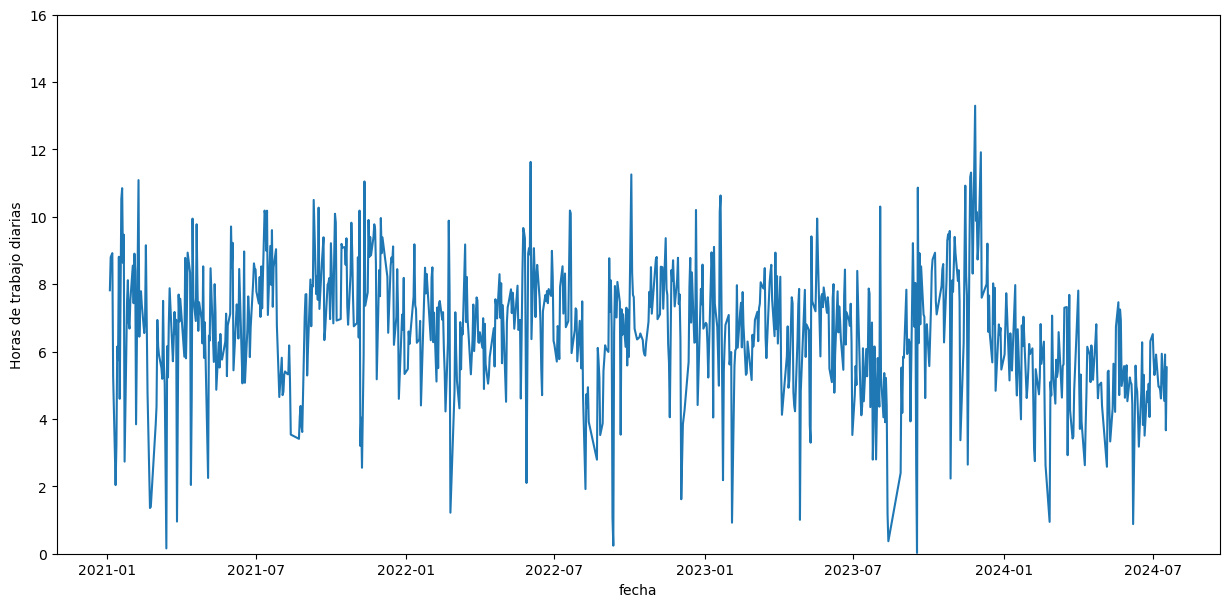

In [28]:
#Trabajo diario, serie muy caótica, dias de la semana aportan poco valor a nivel industrial
dims = (15, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0, 16)
sns.lineplot(data = df_vols_trabajo_diario, x= 'fecha', y= 'tiempo_trabajo_horas')
plt.ylabel('Horas de trabajo diarias')

### Estudiar productos fabricados cada semana

In [29]:
#Estudiar por semanas Y rellenar faltantes
df_vols_trabajo_semanal = df_vols_trabajo_diario.drop('fecha', axis = 1).groupby(by = 'semana').sum().reset_index()

def semana_a_fecha(semana_str):
    year, week = map(int, semana_str.split('-'))
    # Crear una fecha base el primer día del año
    first_day_of_year = pd.Timestamp(year=year, month=1, day=1)
    # Calcular la fecha del primer día de la semana específica
    return first_day_of_year + pd.to_timedelta(week * 7 - first_day_of_year.dayofweek, unit='D')

df_vols_trabajo_semanal['semana_primer_dia'] = df_vols_trabajo_semanal['semana'].apply(semana_a_fecha)

In [30]:
#Rellenar semanas faltantes
semana_min = df_vols_trabajo_semanal['semana_primer_dia'].min()
semana_max = df_vols_trabajo_semanal['semana_primer_dia'].max()
todas_las_semanas = pd.date_range(semana_min, semana_max, freq='W-MON')
df_todas_las_semanas = pd.DataFrame({'semana_primer_dia': todas_las_semanas})
df_completo = pd.merge(df_todas_las_semanas, df_vols_trabajo_semanal, on='semana_primer_dia', how='left')
df_completo['cantidad_fabricada'].fillna(0, inplace=True)
df_completo['tiempo_trabajo'].fillna(0, inplace=True)
df_completo['tiempo_trabajo_horas'].fillna(0, inplace=True)
df_completo['semana'] = df_completo['semana_primer_dia'].dt.isocalendar().week.astype(str) + "-" + df_completo['semana_primer_dia'].dt.year.astype(str)
df_vols_trabajo_semanal = df_completo

In [31]:
df_vols_trabajo_semanal

,semana_primer_dia,semana,cantidad_fabricada,tiempo_trabajo,tiempo_trabajo_horas
0,2021-01-04,1-2021,1128.0,110917.739110,30.810483
1,2021-01-11,2-2021,1111.0,110080.856633,30.578016
2,2021-01-18,3-2021,1608.0,151985.738948,42.218261
3,2021-01-25,4-2021,1243.0,132033.538472,36.675983
4,2021-02-01,5-2021,1298.0,133630.835269,37.119676
...,...,...,...,...,...
180,2024-06-17,25-2024,806.0,85394.186966,23.720607
181,2024-06-24,26-2024,791.0,89037.134149,24.732537
182,2024-07-01,27-2024,902.0,104435.828653,29.009952
183,2024-07-08,28-2024,882.0,91153.452316,25.320403


<Axes: xlabel='semana', ylabel='cantidad_fabricada'>

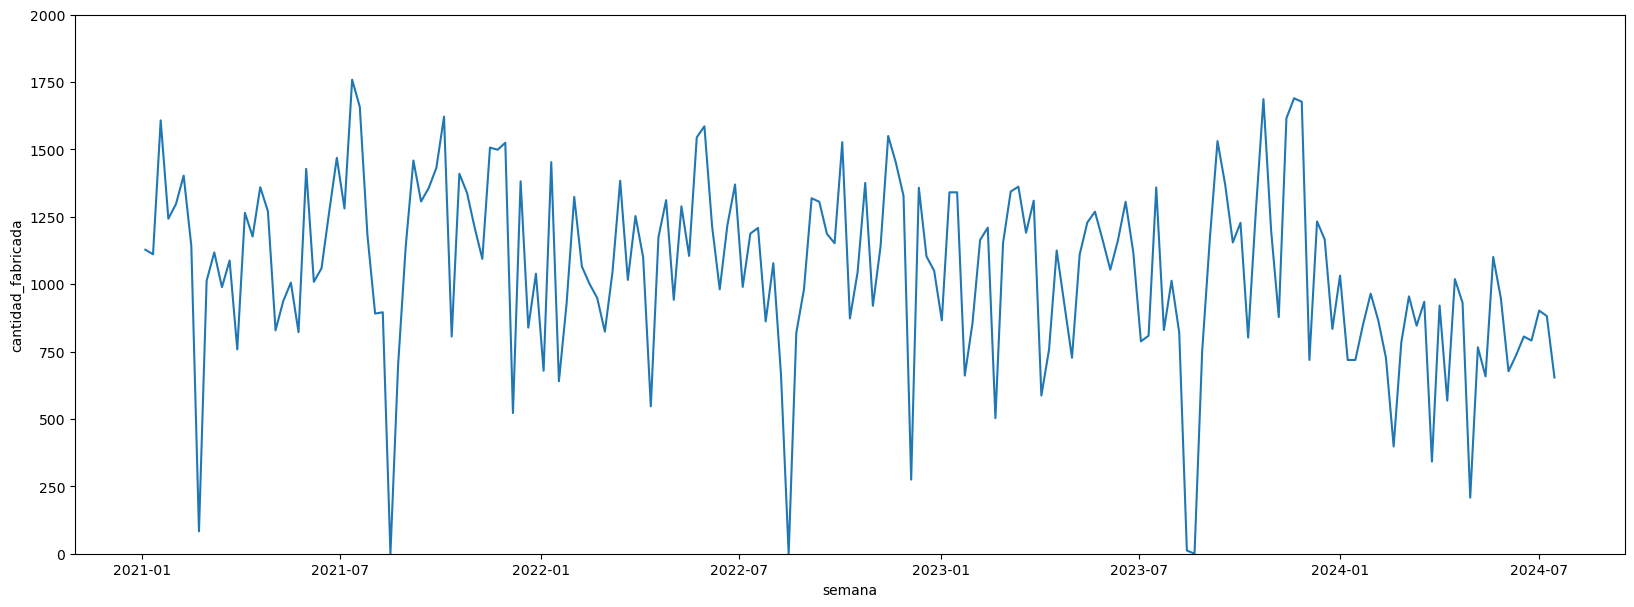

In [32]:
#Trabajo Semanal en cantidad de productos 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0, 2000)
plt.xlabel("semana")
sns.lineplot(data = df_vols_trabajo_semanal, x= 'semana_primer_dia', y= 'cantidad_fabricada')

<Axes: xlabel='semana', ylabel='tiempo_trabajo_horas'>

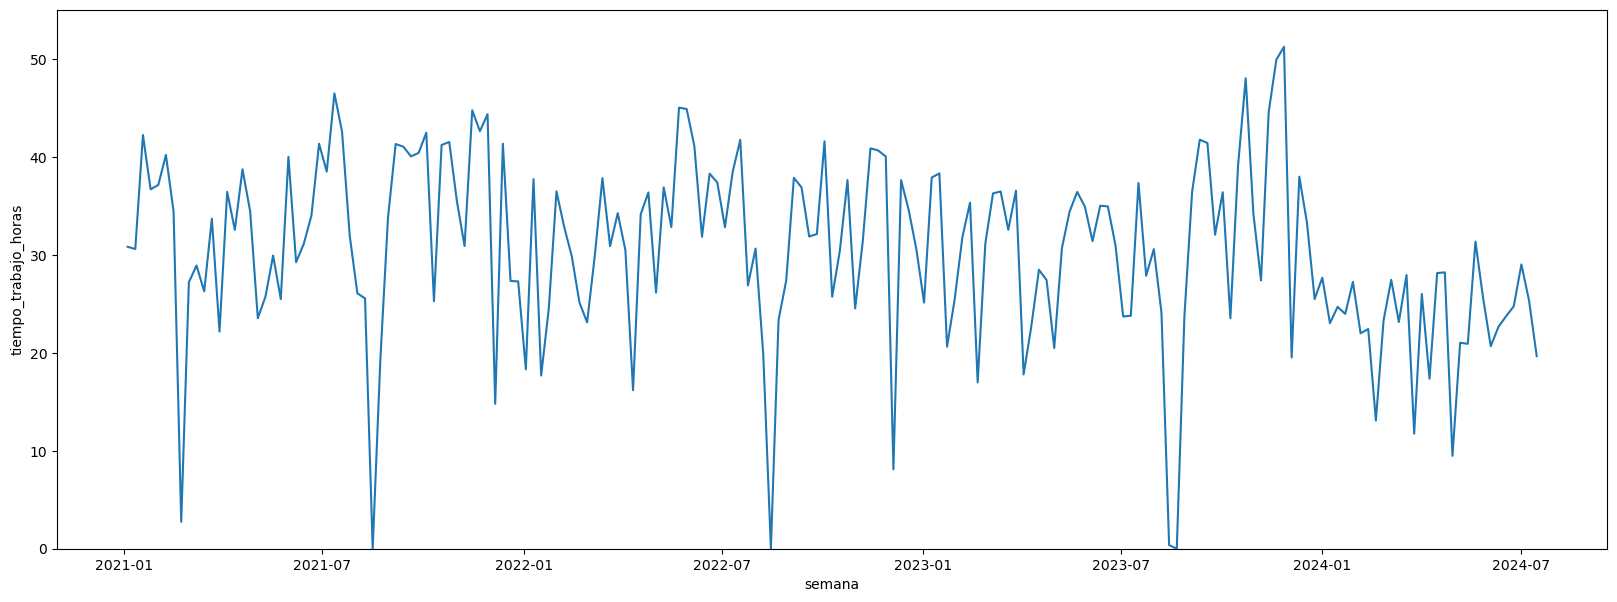

In [33]:
#Trabajo Semanal en Horas 
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)
ax.set_ylim(0, 55)
plt.xlabel("semana")
sns.lineplot(data = df_vols_trabajo_semanal, x= 'semana_primer_dia', y= 'tiempo_trabajo_horas')

### Estudiar descomposición de serie temporal

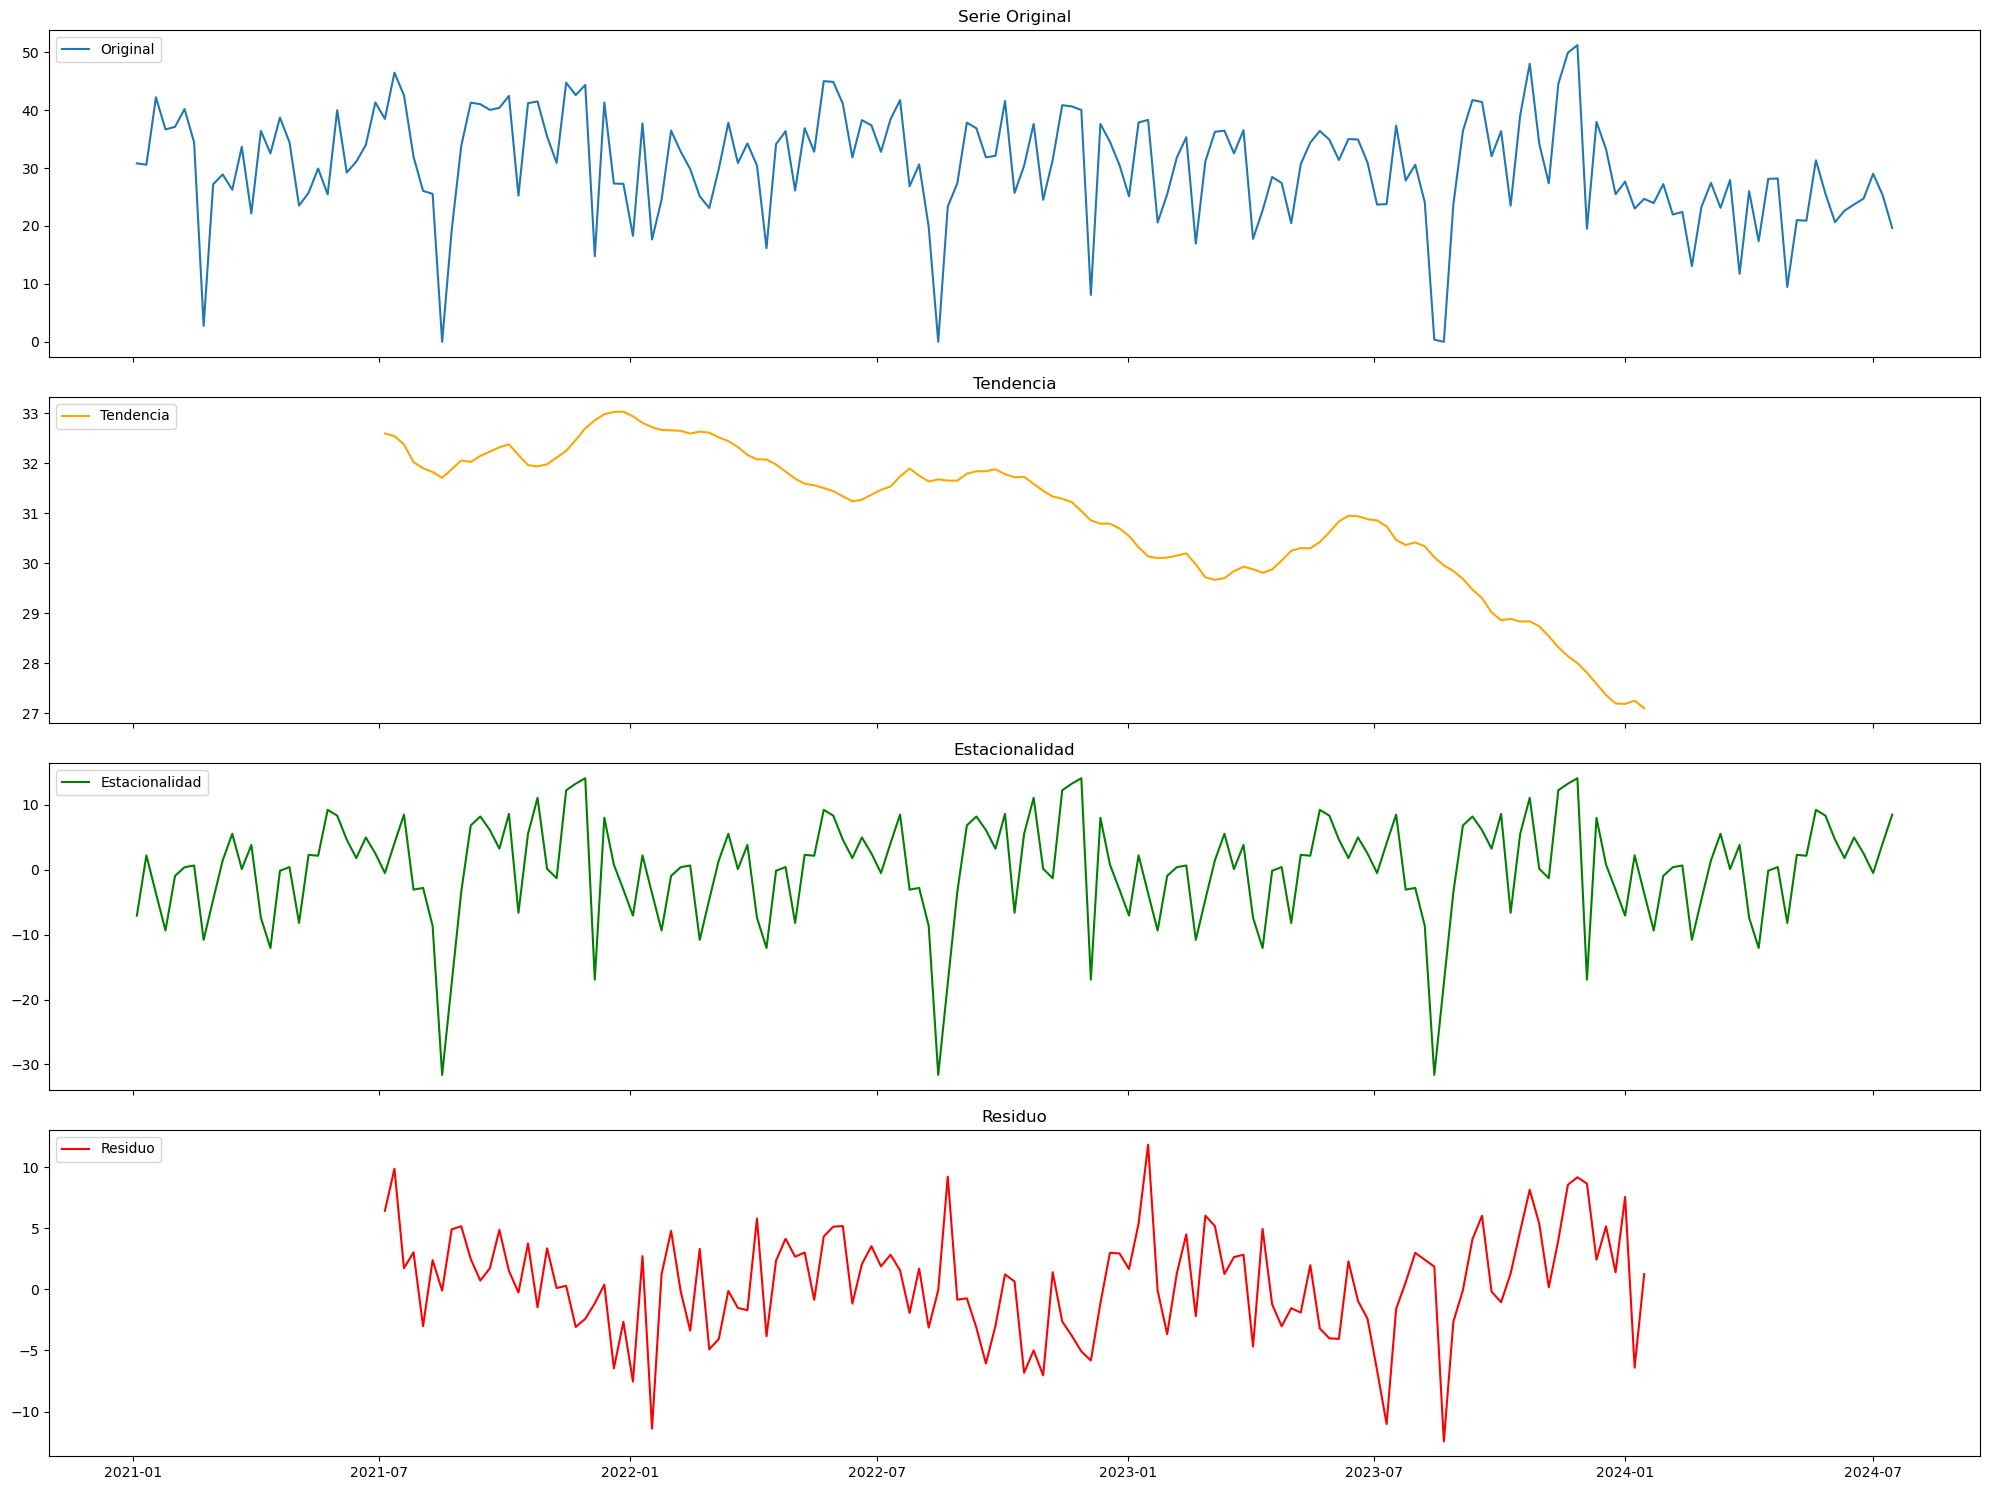

In [34]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#Preparar dataset
serie_descomponer = df_vols_trabajo_semanal.rename(columns={"semana_primer_dia": "ds", "tiempo_trabajo_horas": "y"})
serie_descomponer = serie_descomponer.drop(['semana', 'cantidad_fabricada', 'tiempo_trabajo'], axis=1)

# Asegúrar de que la columna 'ds' es de tipo fecha y sea el índice
serie_descomponer['ds'] = pd.to_datetime(serie_descomponer['ds'])
serie_descomponer.set_index('ds', inplace=True)

# Realizamos la descomposición
result = seasonal_decompose(serie_descomponer, model='additive', period=52)

# Extraemos cada componente
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Configuramos el tamaño de la figura y graficamos cada componente manualmente
fig, axs = plt.subplots(4, 1, figsize=(20, 15), sharex=True)

# Gráfico original
axs[0].plot(serie_descomponer, label='Original')
axs[0].legend(loc='upper left')
axs[0].set_title('Serie Original')

# Gráfico de la Tendencia
axs[1].plot(trend, label='Tendencia', color='orange')
axs[1].legend(loc='upper left')
axs[1].set_title('Tendencia')

# Gráfico de la Estacionalidad
axs[2].plot(seasonal, label='Estacionalidad', color='green')
axs[2].legend(loc='upper left')
axs[2].set_title('Estacionalidad')

# Gráfico del Residuo
axs[3].plot(residual, label='Residuo', color='red')
axs[3].legend(loc='upper left')
axs[3].set_title('Residuo')

plt.tight_layout()
plt.show()


In [35]:
#Exportar Dataframe para usarlo como punto de partida en resto del proyecto
df_vols_trabajo_semanal.to_excel('./dataframes/df_vols_trabajo_semanal.xlsx')